<a href="https://colab.research.google.com/github/andrearyang/housing/blob/main/housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
import sklearn

def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
  return pd.read_csv(Path("datasets/housing/housing.csv"))

In [2]:
housing = load_housing_data()

In [3]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# stratified sampling
from sklearn.model_selection import train_test_split

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins = [0., 1.5, 3, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
strat_train_set, strat_test_set = train_test_split(housing, test_size = 0.2, stratify=housing["income_cat"], random_state=42)

In [6]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [7]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

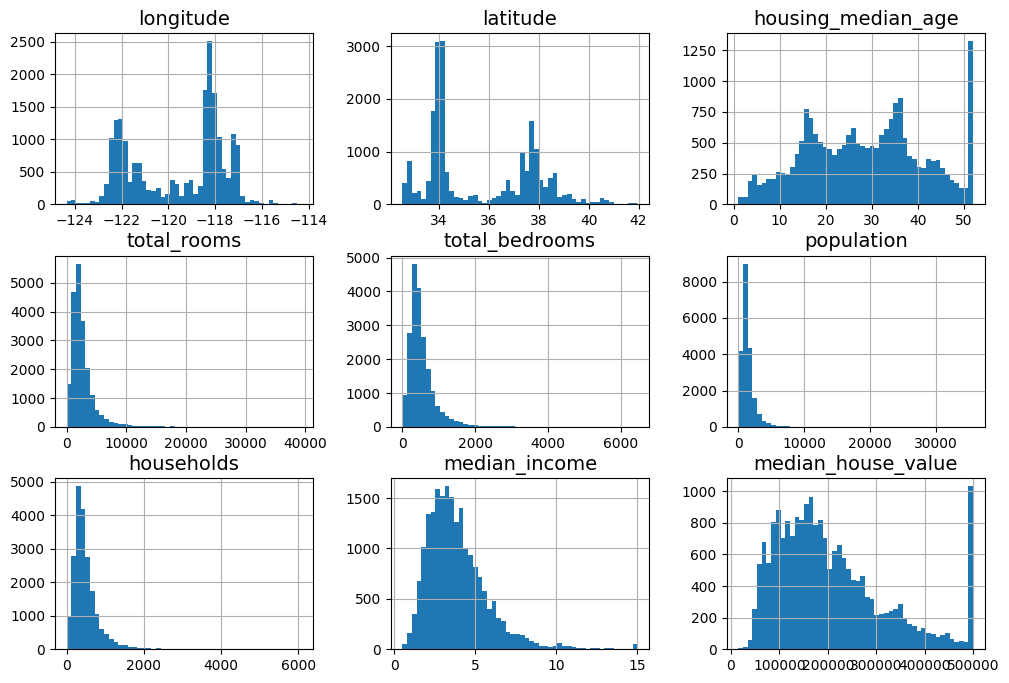

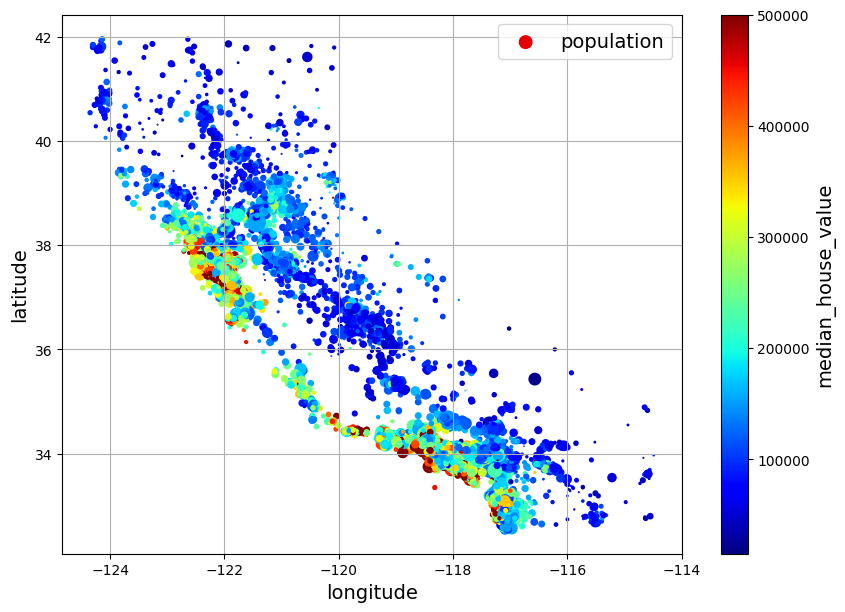

In [8]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
plt.show()

housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10,7))
plt.show()

In [9]:
corr_matrix = housing.corr(numeric_only=True)

corr_matrix["median_house_value"].sort_values(ascending=True)

latitude             -0.139584
longitude            -0.050859
population           -0.020153
total_bedrooms        0.054635
households            0.071426
housing_median_age    0.102175
total_rooms           0.137455
median_income         0.688380
median_house_value    1.000000
Name: median_house_value, dtype: float64

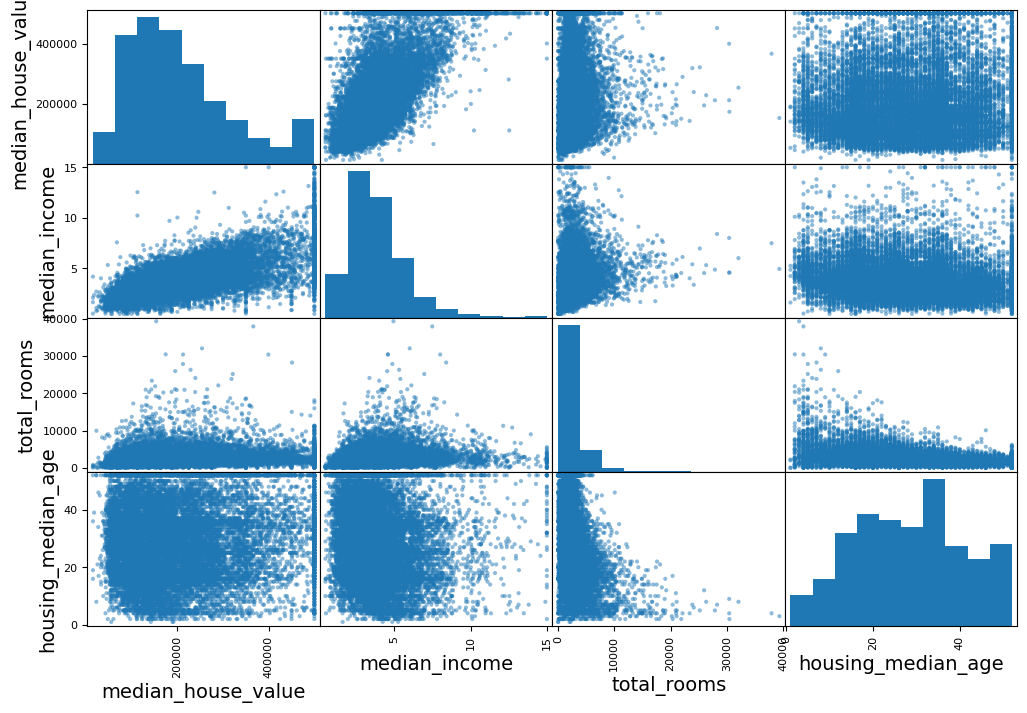

In [10]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

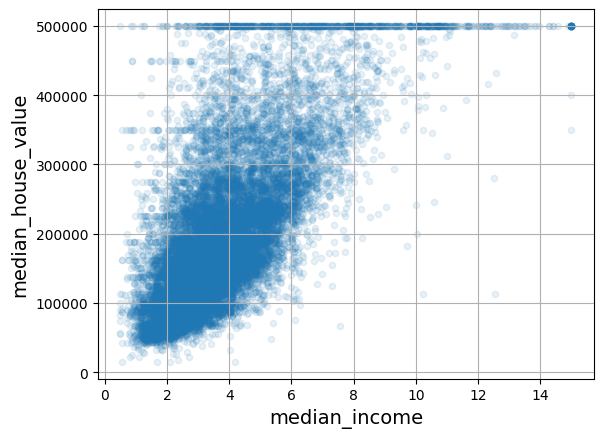

In [11]:
housing.plot(kind="scatter", x="median_income",y="median_house_value", alpha=0.1, grid=True)

In [12]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [13]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [14]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_nums = housing.select_dtypes(include=np.number)
imputer.fit(housing_nums)
imputer.statistics_
housing_nums.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [15]:
X = imputer.transform(housing_nums)
housing_tr = pd.DataFrame(X, columns=housing_nums.columns,
                          index = housing_nums.index)

In [16]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

ocean_proximity
13096        NEAR BAY
14973       <1H OCEAN
3785           INLAND
14689          INLAND
20507      NEAR OCEAN
1286           INLAND
18078       <1H OCEAN
4396         NEAR BAY

In [17]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat)
encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [18]:
encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [19]:
encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [20]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler(feature_range=(-1, 1))
housing_nums_min_max_scaled = minmax.fit_transform(housing_nums)

In [21]:
# custom transformer for the logarithm function

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())
model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [24]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [28]:
def column_ratio(X):
  return X[:,[0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
  return ["ratio"]

def ratio_pipeline():
  return make_pipeline(
      SimpleImputer(strategy="median"),
      FunctionTransformer(column_ratio, feature_names_out=ratio_name),
      StandardScaler()
  )

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
],
remainder=default_num_pipeline)

In [29]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [30]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7ac...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7acb7b351490>)])),
                ('linearregression', LinearRegression())])

In [31]:
lin_predictions = lin_reg.predict(housing)
lin_predictions[:5].round(-2)

array([242800., 375900., 127500.,  99400., 324600.])

In [32]:
housing_labels.iloc[:5].round(-2)

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
Name: median_house_value, dtype: float64

In [33]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, lin_predictions)
lim_rmse = np.sqrt(lin_rmse)
lim_rmse

np.float64(68647.95686706658)

In [34]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_rmse)
tree_rmse

np.float64(0.0)

In [35]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [36]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66366.983603
std       1976.844743
min      63557.655007
25%      65004.623899
50%      65886.897085
75%      68129.026040
max      69530.301101
dtype: float64

In [37]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     46938.209246
std       1018.397196
min      45522.649195
25%      46291.334639
50%      47021.703303
75%      47321.521991
max      49140.832210
dtype: float64

In [39]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_rmse)
forest_rmse

np.float64(17521.565358779884)

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7acb7b351490>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [41]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [42]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7acb7b3...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7acb7da3f4d0>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [43]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
12       8.485339      0.301379         0.202175        0.023678   
13      11.046749      0.022169         0.179679        0.001294   
7        8.333051      0.550026         0.193238        0.016260   
9        8.129702      0.313519         0.176959        0.001659   
6        5.908642      0.330357         0.203645        0.025697   

    param_preprocessing__geo__n_clusters  param_random_forest__max_features  \
12                                    15                                  6   
13                                    15                                  8   
7                                     10                                  6   
9                                     10                                  6   
6                                     10                                  4   

                                               params  split0_test_score  \
12  {'preprocessing__geo__n_clusters': 15, 'random...      -43006.650208   
13  {'preprocessing__geo__n_clusters': 15, 'random...      -43696.807883   
7   {'preprocessing__geo__n_clusters': 10, 'random...      -43709.661050   
9   {'preprocessing__geo__n_clusters': 10, 'random...      -43709.661050   
6   {'preprocessing__geo__n_clusters': 10, 'random...      -43797.854175   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
12      -43683.244212      -44158.332131    -43616.075517      472.565014   
13      -44011.195266      -44819.026722    -44175.676624      472.676329   
7       -44132.827198      -45226.940308    -44356.476185      639.295570   
9       -44132.827198      -45226.940308    -44356.476185      639.295570   
6       -44232.653866      -45100.371162    -44376.959735      541.452222   

    rank_test_score  
12                1  
13                2  
7                 3  
9                 3  
6                 5

In [44]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7acb7dc48650>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7acb8447df10>},
                   random_state=42, scoring='neg_root_mean_squared_error')

# Analyzing

In [46]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.  , 0.02, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [47]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(np.float64(0.18883049114642353), 'log__median_income'),
 (np.float64(0.07550690165952419), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06427087748676082), 'bedrooms__ratio'),
 (np.float64(0.0521695509969851), 'rooms_per_house__ratio'),
 (np.float64(0.04664258696240615), 'people_per_house__ratio'),
 (np.float64(0.04244311259449021), 'geo__Cluster 3 similarity'),
 (np.float64(0.02329106317954673), 'geo__Cluster 17 similarity'),
 (np.float64(0.022649484211911694), 'geo__Cluster 18 similarity'),
 (np.float64(0.02197243576680579), 'geo__Cluster 22 similarity'),
 (np.float64(0.01881537204558837), 'geo__Cluster 40 similarity'),
 (np.float64(0.01766998676736003), 'geo__Cluster 10 similarity'),
 (np.float64(0.01754694953848625), 'geo__Cluster 35 similarity'),
 (np.float64(0.017274903717750808), 'geo__Cluster 41 similarity'),
 (np.float64(0.016055663107420095), 'geo__Cluster 6 similarity'),
 (np.float64(0.015811758952117744), 'geo__Cluster 2 similarity'),
 (np.float64(0.01477755940463033), 

# Evaluate

In [49]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_rmse)
print(final_rmse)

41556.053474456494


In [50]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39415.11928419, 43591.96637635])

# Push

In [51]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']